# Agenda
*   Build a BERT pipeline for classification using an ML model and a pretrained BERT model for feature. 
*   Compare results with classical feature transformation(extraction) techniques



In [ ]:
%%capture
!pip install pytorch_pretrained_bert

In [ ]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import io
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preperation

In [ ]:
# Download the dataset
!gdown --id 1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL
To: /content/in_domain_train.tsv
100% 429k/429k [00:00<00:00, 45.3MB/s]


In [ ]:
# Read into a pandas dataframe
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])[['label', 'sentence']]
df

,label,sentence
0,1,"Our friends won't buy this analysis, let alone..."
1,1,One more pseudo generalization and I'm giving up.
2,1,One more pseudo generalization or I'm giving up.
3,1,"The more we study verbs, the crazier they get."
4,1,Day by day the facts are getting murkier.
...,...,...
8546,0,Poseidon appears to own a dragon
8547,0,Digitize is my happiest memory
8548,1,It is easy to slay the Gorgon.
8549,1,I had the strangest feeling that I knew you.


In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

# Bert tokenization
Apply bert tokenizer over each sentence

In [ ]:
from pytorch_pretrained_bert import BertTokenizer # You will need this module

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
tokenized_texts = []
# Tokenize the sentences and put them in the list tokenized_texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [ ]:
input_ids = []
# Convert the tokens to their index numbers (input_ids) in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


# Create the attention mask

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Conver the ids into a tensor representation
batch_size = 8
input_tensor = torch.tensor(input_ids)
masks_tensor = torch.tensor(attention_masks)
train_data = TensorDataset(input_tensor, masks_tensor)
dataloader = DataLoader(train_data, batch_size=batch_size)

# Bert model
Initialize the bert model and feed in all the sentences to get the encoded vectors

In [ ]:
# Initialize the model
model = BertModel.from_pretrained("bert-base-uncased").to('cuda')

In [ ]:
model.eval()
outputs = []
for input, masks in dataloader:
  torch.cuda.empty_cache() # empty the gpu memory

  # Transfer the batch to gpu
  input = input.to('cuda')
  masks = masks.to('cuda')

  # Run inference on the batch
  output = model(input, output_all_encoded_layers=False, attention_mask=masks)[0]

  # Transfer the output to CPU again and convert to numpy
  output = output.cpu().detach().numpy()

  # Store the output in a list
  outputs.append(output)

# Concatenate all the lists within the list into one list
outputs = [x for y in outputs for x in y]

In [ ]:
np.shape(outputs)

(8551, 128, 768)

# Your turn
1.   Aggregate the encoded represntation (use mean)
2.   Apply a classical transformation of your choice (BOW - TFIDF - word2vec - etc...), you can use the bert tokenizer.
3.   Plot 2 T-sne plots, one for both representations and comment.
4. Apply an ML model of your choice over both representations and comment.



In [ ]:
X= np.mean(outputs,axis = 2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer()
X_tf=tf.fit_transform(sentences).toarray()

In [ ]:
pd.DataFrame(X_tf,columns=tf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,10,100,1000,11,12,120,12th,13th,1492,...,yourself,yourselves,yuko,zapotec,zebras,zeke,zigzagged,zimmerman,zone,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne=TSNE(n_components=2)
m=tsne.fit_transform(X_tf)
m

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([[ 21.720543,   8.051327],
       [ 90.011734, -61.669296],
       [ 90.01259 , -61.670113],
       ...,
       [ 47.679676, -44.28507 ],
       [ 31.875414,  26.546432],
       [ 23.670256, -10.77114 ]], dtype=float32)

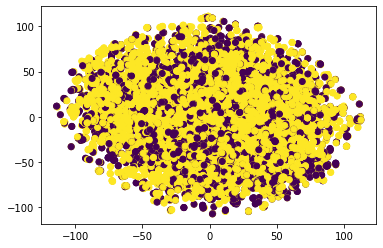

In [ ]:
plt.scatter(m[:,0],m[:,1],c=df['label'])
plt.show()

In [ ]:
tsne=TSNE(n_components=2)
n=tsne.fit_transform(X)
n

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


array([[ -5.0043817,  87.2603   ],
       [-24.353466 ,  48.43064  ],
       [-24.32464  ,  48.435844 ],
       ...,
       [ 18.60201  , -60.415104 ],
       [ 20.145857 , -54.05456  ],
       [-42.721004 ,   2.4011445]], dtype=float32)

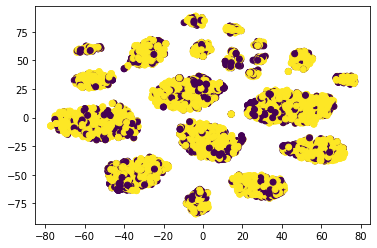

In [ ]:
plt.scatter(n[:,0],n[:,1],c=df['label'])
plt.show()

In [ ]:
nb_tf = MultinomialNB()
nb_tf.fit(x_train,y_train)

In [ ]:
y_pred=nb_tf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
cm

In [ ]:
print(classification_report(y_train,nb_tf.predict(x_train)))
print(classification_report(y_test,y_pred))